In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

from matplotlib.patches import Rectangle

In [3]:
def F_nu(t_p,nu_p,F_nup,nu_sed):
    '''Calculates a Synchrotron Self-Absorbed Spectrum for given input parameters.
     axs
    Parameters:
    t_p (days): Time of SSA peak - should be single number
    nu_p (GHz): Frequency of SSA peak - should be single number
    F_nup (mJy): Flux of SSA peak - should be single number
    nu (GHz): Frequencies at which you want the SSA spectrum to be calculated at. Likely an array.
    
    Outputs:
    Fnu (mJy): the flux of the SSA. This is an array with values associated with each value of input array nu.
    '''
    
    m = 0.88 #using stAandard model m = (n-3)/(n-2)
    p = 3.0 #using standard model
    a = (2*m)+0.5
    b = (p+5-(6*m))/2
    t=t_p
    Fnu = F_nup*1.582*(t/t_p)**a*(nu_sed/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu_sed/nu_p)**(-(p+4)/2)))
    
    return Fnu


def SSA_props(t_p,nu_p,F_nup,D,f=0.5,alpha=1,vw=100,epsilon_b=0.1):
    '''Calculates Synchroton Self-Absorption properties for given input parameters.
    
    Inputs:
    t_p (days): Time of SSA peak - likely a single number
    nu_p (GHz): Frequency of SSA peak - likely a single number
    F_nup (mJy): Flux of SSA peak - likely a single number
    D (Mpc): distance to SN - likely a single number,while D_L is the luminosity distance
    f (unitless): filling factor (fraction of emitting region). default is 0.5
    alpha (unitless): ratio charged particles to magnetic field (epsilon_e/epsilon_b). default 1
    v_w (km/s): wind speed. default = 100
    epsilon_b (unitless): fraction of shock energy into B-fields. default = 0.1
    
    Outputs:
    R (cm): radius of material 
    B : magnetic field flux
    E : intermal energy of emitting material
    v (km/s): expansion velocity of material
    M (1d-5 solar masses per year): inferred mass loss rate of progenitor'''
     #angular distance
    D = D_L/((1+z)**2)

    #Radius
    R = 4.0e14*(alpha)**(-1./19.)*(f/0.5)**(-1./19.)*(F_nup)**(9./19.)*(D)**(18./19.)*(nu_p/5.)**(-1)

    # Magnetic field flux
    B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

    #Internal energy of the emitting material
    E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3.)

    #expansion velocity in km/s
    v = (R/t_p)*1.1574e-10

    #pre-explosion mass-loss in 1e- axs5 solar mass per year
    M = 1.0*(alpha)**(-8./19.)*(epsilon_b/0.1)*(f/0.5)**(-8./19.)*(F_nup)**(-4./19.)*(D)**(-4./19.)*(nu_p/5.)*(t_p/10.)*(vw/1000.)
    
   

    return R,B,E,v,M


def taufreefree(M,R,nu):
    '''Calculates the free free optical depth for a given set of parameters.
    
    Inputs:
    M (1d-5 solar masses per year): mass loss rate
    R (cm): radius of emitting material
    nu (GHz): Frequencies at which you want tau-ff to be calculated at. Likely an array.
    
    Outputs:
    tau_ff (unitless): the free-free optical depth, calculated at same frequences as input array nu'''

    Z_ave = 5.4  # Average metallicity 1= pure H. 5.4 for a massive star
    miu = 1.9 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
    vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
    T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 
        
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units
    
    tau_ff = 2.021e25*M_cgs**2*Z_ave/(miu**2*nu**(2.1)*R**3*vw_cgs**2*T**(1.35))  
    
    return tau_ff

def den(M,R):
    vw_cgs = 100 * 1e5
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
        #density of the CSM
    density = M_cgs/(4*3.142*R**2*vw_cgs)
    
    return density
#freqs,SED = F_nu(1224.288326 , 8,  0.0272)       
#R2,B2,E2,v2,M2 = SSA_props(1224.288326 , 8,  0.0272,880) 
#tauff=taufreefree(M2,R2,freqs)
#tauff=taufreefree(4,3e14,np.array([2,5,7]))
#print(freqs)
#print(tauff)
#print(R2,B2,E2,v2,M2)

Text(1.2, 0.045, '$\\.{M} = 6.29-10.19\\times 10^{-4}$ M$_{\\odot}$ yr$^{-1}$')

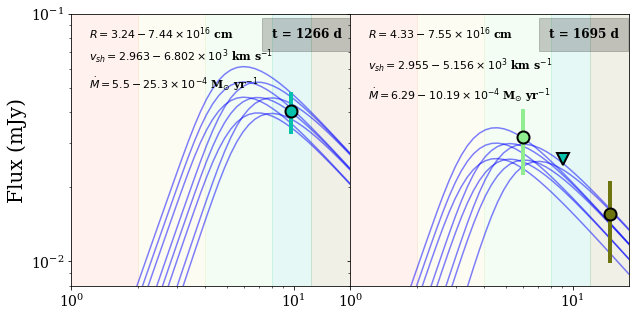

In [6]:
#plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
#figure, subplots = plt.subplots(1, 2, figsize=(18,10))
#figure.rcParams.update({'font.size': 10})
#fig = fig.add_subplot(111) 
fig,subplots = plt.subplots(1, 2,figsize=(10,5), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})

#### LEFT:

subplots[0].set_xscale('log')
subplots[0].set_yscale('log')

file_in = 'PS11aop_grid_e1+5.csv'
data_plot = ascii.read(file_in)
D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5.5 #55736.161 #inferred explosion date
date_obs = 57307.08 # date that radio obs was taken
redshift = 0.218 # redshift of object
z = 0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#

file_in1 = 'PS11aop_grid_e2+5.csv'
data_plot1 = ascii.read(file_in1)
index1 = np.where(data_plot1['RuledOut'] == 'False')[0]
data_plot1a = data_plot[index1]

#Allowed
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
index2a = np.where(data_plota['Radius'] < np.max(data_plot1a['Radius']))[0]
data_plota = data_plota[index2a]
index3a = np.where(data_plota['v_shock'] > np.min(data_plot1a['v_shock']))[0]
data_plota = data_plota[index3a]
#index4 = np.where(data_plot['Mdot'] > 0.85)[0]
#data_plot = data_plot[index4]
#index5 = np.where(data_plot['Mdot'] < 1.5)[0]
#data_plot = data_plot[index5]

Fcalc = data_plota['F_peak'][0:10]
nucalc = data_plota['nu_peak'][0:10]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[0].plot(nu_sed,SSA_FFA_sed,'b',zorder=1,alpha=0.5)

 #Not allowed
# indexb = np.where(data_plot['RuledOut'] == 'True')[0]
# data_plotb = data_plot[indexb]
# index2b = np.where(data_plotb['Radius'] < 7.5e16)[0]
# data_plotb = data_plotb[index2b]
# index3b = np.where(data_plotb['v_shock'] > 2500.)[0]
# data_plotb = data_plotb[index3b]
# #index4 = np.where(data_plot['Mdot'] > 0.85)[0]
# #data_plot = data_plot[index4]
# #index5 = np.where(data_plot['Mdot'] < 1.5)[0]
# #data_plot = data_plot[index5]

# Fcalc1 = data_plotb['F_peak'][0:300:20]
# nucalc1 = data_plotb['nu_peak'][0:300:20]
# nu_sed1=np.logspace(np.log10(0.1),np.log10(50),num=100)

# for i in range(len(Fcalc1)):
#     #calculate SSA
#     SSA_sed1 = F_nu(t_p,nucalc1[i],Fcalc1[i],nu_sed1)
    
#     #calculate Mass loss rate, Radius, velocity, etc.
#     R1,B1,E1,v1,M1 = SSA_props(t_p,nucalc1[i],Fcalc1[i],D)

#     #calculate tau_ff
#     tauff1 = taufreefree(M1,R1,nu_sed1)
        
#     #Correct SED for FFA:
#     SSA_FFA_sed1 = SSA_sed1*np.exp(-tauff1)
    
#     #Plot it:
#     subplots[0].plot(nu_sed1,SSA_FFA_sed1,'r',zorder=1,alpha=0.5)
    
#Overplot the data:
subplots[0].errorbar(9.77,0.0405,0.0078,fmt ='o',color='xkcd:turquoise',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
#subplots[0].text(1.1,0.04,'Allowed',color = 'b',fontsize=15,bbox={'facecolor': 'b', 'alpha': 0.2, 'pad': 5})
#subplots[0].text(1.1,0.03,'Not Allowed',color='r',fontsize=15,bbox={'facecolor': 'r', 'alpha': 0.2, 'pad': 5})
r1e = Rectangle((1,5e-3),1,0.095,color='coral',alpha=0.1,zorder=1)
r2e = Rectangle((2,5e-3),2,0.095,color='khaki',alpha=0.1,zorder=1)
r3e = Rectangle((4,5e-3),4,0.095,color='lightgreen',alpha=0.1,zorder=1)
r4e = Rectangle((8,5e-3),4,0.095,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5e = Rectangle((12,5e-3),6,0.095,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[0].add_patch(r1e)
subplots[0].add_patch(r2e)
subplots[0].add_patch(r3e)
subplots[0].add_patch(r4e)
subplots[0].add_patch(r5e)


#subplots[0,0].xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots[0].set_ylabel('Flux (mJy)', fontsize=20) 
#subplots[0].title.set_text('PS1-11aop 2015B Observations')   
subplots[0].title.set_fontsize(16) 
subplots[0].set_ylim(8e-3,1e-1)
subplots[0].set_xlim(1,18)
subplots[0].text(8,0.08,'t = 1266 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})
subplots[0].text(1.2,0.065,r'$v_{sh} = 2.963-6.802\times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
subplots[0].text(1.2,0.05,r'$\.{M} = 5.5-25.3\times 10^{-4}$ M$_{\odot}$ yr$^{-1}$',fontsize=11,fontweight='bold')
subplots[0].text(1.2,0.08,r'$R = 3.24-7.44\times 10^{16}$ cm',fontsize=11,fontweight='bold')

#constrained epoch 1 for -5.5 days, max v =6802.2508770775,min=2963, min r =3.2412241536982116e+16
#max r =7.440657640837382e+16, max Mdot = 25.3 , min Mdot = 5.5

####RIGHT:

subplots[1].set_xscale('log')
subplots[1].set_yscale('log')


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5.5 #55736.161 #inferred explosion date
date_obs = 57829.76513 # date that radio obs was taken
redshift = 0.218 # redshift of object
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_in = 'PS11aop_grid_e2+5.csv'
data_plot = ascii.read(file_in)


#Allowed
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]

Fcalc = data_plota['F_peak'][0:10]
nucalc = data_plota['nu_peak'][0:10]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[1].plot(nu_sed,SSA_FFA_sed,'b',zorder=1,alpha=0.5)

 #Not allowed
# indexb = np.where(data_plot['RuledOut'] == 'True')[0]
# data_plotb = data_plot[indexb]

# Fcalc1 = data_plotb['F_peak'][0:1800:44]
# nucalc1 = data_plotb['nu_peak'][0:1800:44]
# nu_sed1=np.logspace(np.log10(0.1),np.log10(50),num=100)

# for i in range(len(Fcalc1)):
#     #calculate SSA
#     SSA_sed1 = F_nu(t_p,nucalc1[i],Fcalc1[i],nu_sed1)
    
#     #calculate Mass loss rate, Radius, velocity, etc.
#     R1,B1,E1,v1,M1 = SSA_props(t_p,nucalc1[i],Fcalc1[i],D)

#     #calculate tau_ff
#     tauff1 = taufreefree(M1,R1,nu_sed1)
        
#     #Correct SED for FFA:
#     SSA_FFA_sed1 = SSA_sed1*np.exp(-tauff1)
    
#     #Plot it:
#     subplots[1].plot(nu_sed1,SSA_FFA_sed1,'r',zorder=1,alpha=0.5)
#Overplot the data:
#plt.plot(3.0,0.405, 'kv', markersize=10)
subplots[1].errorbar(6.0,0.0318,0.0095,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[1].plot(9.02,0.0258, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
subplots[1].errorbar(14.74,0.0155, 0.0056,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)


r1d = Rectangle((1,5e-3),1,0.095,color='coral',alpha=0.1,zorder=1)
r2d = Rectangle((2,5e-3),2,0.095,color='khaki',alpha=0.1,zorder=1)
r3d = Rectangle((4,5e-3),4,0.095,color='lightgreen',alpha=0.1,zorder=1)
r4d = Rectangle((8,5e-3),4,0.095,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5d = Rectangle((12,5e-3),6,0.095,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[1].add_patch(r1d)
subplots[1].add_patch(r2d)
subplots[1].add_patch(r3d)
subplots[1].add_patch(r4d)
subplots[1].add_patch(r5d)


#subplots[1].set_xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
#subplots[0,1].set_ylabel('Flux (mJy)', fontsize=20) 
#subplots[1].title.set_text('PS1-11aop 2017A Observations') 
subplots[1].title.set_fontsize(16) 
subplots[1].set_ylim(8e-3,1e-1)
subplots[1].set_xlim(1,18)
subplots[1].text(7.8,0.08,'t = 1695 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})
subplots[1].text(1.2,0.08,r'$R = 4.33-7.55\times 10^{16}$ cm',fontsize=11,fontweight='bold')
subplots[1].text(1.2,0.06,r'$v_{sh} = 2.955-5.156\times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
subplots[1].text(1.2,0.045,r'$\.{M} = 6.29-10.19\times 10^{-4}$ M$_{\odot}$ yr$^{-1}$',fontsize=11,fontweight='bold')

#epoch 2 for 5.5days , min v =2955.653628454705,max v=5156.192888770475, min R =4.3289282514104936e+16
# max R =7.551896085195307e+16, min Mdot = 6.29, max Mdot = 10.19

#fig.text(0.5, 0.03,r'$\nu$(GHz)',fontsize=20, va='center',ha ='center')

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.tight_layout()
#plt.savefig('SEDps11aop5.png',dpi = 500, transparent = True)
#plt.show()

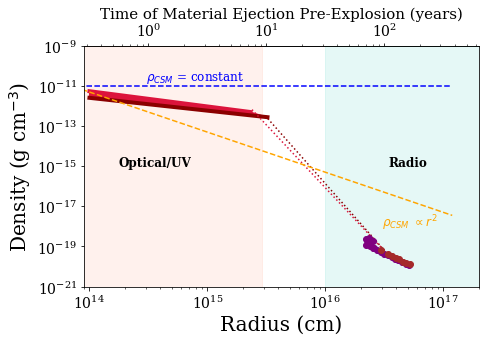

In [7]:
#5.5 days post explosion


## DENSITY PLOT:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
figure, subplots = plt.subplots(1, 1, figsize=(7,5))
#figure.rcParams.update({'font.size': 10})


###PUT ON THE SHELL MATERIAL:

#THESE PLOTS LINES FOR THE FOUR MODELS:

#PS11aop: CSM
subplots.plot([1e14,2.32e15],[5.49*10.**(-12),5.03E-13],color='crimson',linewidth=4)

#PS11aop: CSM_NI
subplots.plot([1e14,3.23e15],[2.57*10.**(-12),2.78E-13],color='darkred',linewidth=4)


#THIS WILL FILL IN THE REGION BETWEEN THE MODELS FOR PS1-11vo and PS1-11aop. 

ps11aop_x = [1e14,2.32e15,3.23e15,1e14,1e14]
ps11aop_y = [5.49*10.**(-12),5.03E-13,2.78E-13,2.57*10.**(-12),2.57*10.**(-12)]
subplots.fill(ps11aop_x,ps11aop_y,color='crimson',alpha=1,zorder=2)

#Dashed Lines connecting optical to radio:
subplots.plot([2.39e15,3.5412241537e+16],[6.6155e-13,0.3e-19],color='crimson',linestyle=':')
subplots.plot([3.09e15,3.5412241537e+16],[3.3155e-13,0.3e-19],color='darkred',linestyle=':')
#subplots.plot([1.22e15,2.60355962868e+16],[3.67668e-13,5.5e-20],color='turquoise',linestyle=':')

### GET ON THE RADIO EMISSION: 

### PS1-11aop EPOCH #1:
file_in = 'PS11aop_grid_e1+5.csv'
data_plot1 = ascii.read(file_in)
D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5.5 #55736.161 #inferred explosion date
date_obs = 57307.08 # date that radio obs was taken
redshift = 0.218 # redshift of object
z = 0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#

file_in1a = 'PS11aop_grid_e2+5.csv'
data_plot1a = ascii.read(file_in1a)
index1a = np.where(data_plot1a['RuledOut'] == 'False')[0]
data_plot2a = data_plot1a[index1a]

index1 = np.where(data_plot1['RuledOut'] == 'False')[0]
data_plot2 = data_plot1[index1]
index2 = np.where(data_plot2['Radius'] < np.max(data_plot2a['Radius']))[0]
data_plot3 = data_plot2[index2]
index3 = np.where(data_plot3['v_shock'] > np.min(data_plot2a['v_shock']))[0]
data_plot4 = data_plot3[index3]
#index4 = np.where(data_plot4['Mdot'] > 0.85)[0]
#data_plot5 = data_plot4[index4]
#index5 = np.where(data_plot5['Mdot'] < 1.5)[0]
#data_plot6 = data_plot5[index5]

#These just have the density in them already, but there is the typo from above. 
#It is directly proportional, we we plt.rcParams["font.family"] = "serif"
#plt.rcParams.update({'font.size': 15})need to multiply by the correction factor: 

PS11aop_rad1 = data_plot4['Radius']
PS11aop_den1 = data_plot4['den']

subplots.plot(PS11aop_rad1,PS11aop_den1,'o',color='purple')#,markeredgecolor='black', markeredgewidth=2)
#print(np.min(PS11aop_rad1))

###PS1-11aop e2:
D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5.5 #55736.161 #inferred explosion date
date_obs2 = 57829.76513 # date that radio obs was taken
redshift = 0.218 # redshift of object

t_p = (date_obs2 - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_in1a = 'PS11aop_grid_e2+5.csv'
data_plot1a = ascii.read(file_in1a)
index1a = np.where(data_plot1a['RuledOut'] == 'False')[0]
data_plot2a = data_plot1a[index1a]

PS11aop_rad2 = data_plot2a['Radius']
PS11aop_den2 = data_plot2a['den']
subplots.plot(PS11aop_rad2,PS11aop_den2,'o',color='brown')#,markeredgecolor='black', markeredgewidth=2)
r = np.arange(start=0.01, stop=120)*1e15
#den1 = [1e-11,1e-11,1e-11]
import itertools
den1=list(itertools.repeat(1e-11, 120))
den2 = 5e16*r**(-2)
subplots.plot(r,den2, linestyle = '--', color = 'orange')
subplots.plot(r,den1,linestyle = '--', color = 'blue')


### SHOW THE HIGHLIGHTS OF REGIONS/LABELS: 
r1e = Rectangle((1e13,1e-24),2.9e15,9.999e-10,color='coral',alpha=0.1,zorder=1)
r3e = Rectangle((1e16,1e-24),1.9e+17,9.999e-10,color='xkcd:turquoise',alpha=0.1,zorder=1)
#r5e = Rectangle((1e17,1e-24),6e+17,9.999e-10,color='xkcd:olive',alpha=0.1,zorder=1)
subplots.add_patch(r1e)
subplots.add_patch(r3e)
#subplots.add_patch(r5e)

### Put on r^-2 wind-like environment:

subplots.set_xscale('log')
subplots.set_yscale('log')
subplots.set_xlabel(r'Radius (cm)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots.set_ylabel(r'Density (g cm$^{-3}$)', fontsize=20) 
#subplots[0].title.set_text('PS1-11aop and PS1-11')   
subplots.title.set_fontsize(16) 
subplots.set_xlim(0.9e14,2e17)
subplots.set_ylim(1e-21,1e-9)

#subplots.text(1.75e14,1e-15,'Dense Shell',fontsize=12,fontweight='bold')
subplots.text(1.75e14,1e-15,'Optical/UV',fontsize=12,fontweight='bold')
subplots.text(3e14,2e-11,r'$\rho_{CSM}$ = constant',fontsize=12,color='blue')

#subplots.text(1.4e16,1e-15,'Wind-like',fontsize=12,fontweight='bold')
subplots.text(3.4e16,1e-15,'Radio',fontsize=12,fontweight='bold')
subplots.text(3e16,1e-18,r'$\rho_{CSM}$ $\propto r^{2}$',fontsize=12,color = 'orange')

#TIME AXIS MANUAL:
#subplots.text(3.1e14,2.5e-10,'1',fontsize=10,fontweight='bold')
#subplots.text(6.3e14,2.5e-10,'2',fontsize=10,fontweight='bold')
#subplots.text(1.5e15,2.5e-10,'5',fontsize=10,fontweight='bold')
#subplots.text(3.1e15,2.5e-10,'10',fontsize=10,fontweight='bold')
#subplots.text(6.3e15,2.5e-10,'20',fontsize=10,fontweight='bold')
#subplots.text(1.5e16,2.5e-10,'50',fontsize=10,fontweight='bold')
#subplots.text(3.1e16,2.5e-10,'100',fontsize=10,fontweight='bold')
#subplots.text(6.3e16,2.5e-10,'200',fontsize=10,fontweight='bold')
#subplots.text(1.3e17,2.5e-10,'500',fontsize=10,fontweight='bold')
#subplots.text(3.1e17,2.5e-10,'1000',fontsize=10,fontweight='bold')
#subplots.text(6.3e17,2.5e-10,'2000',fontsize=10,fontweight='bold')

#subplots.text(4e14,5e-11,'Time of Material Ejection Pre-Explosion (years)',fontsize=11,fontweight='bold')

#bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10}

def rad2time(x):
    return x/100e5/86400./365.  #time (years) = radius(cm) /wind speed (100km/s---> 100e5 cm/s)


def time2rad(x):
    return x*365*86400.*100e5   #radius (cm) = time(years) *wind speed

secax = subplots.secondary_xaxis('top', functions=(rad2time, time2rad))
secax.set_xlabel('Time of Material Ejection Pre-Explosion (years)')
plt.tight_layout()
#plt.savefig('VLA2021A_Densities.pdf')
#plt.savefig('densityplot2a5.png',dpi = 500, transparent = True)

plt.show()


In [9]:
np.min(data_plot2['Mdot']) # #epoch 2 for 5.5days 

0.1296685563553052

In [14]:
np.max(data_plot4['Mdot'])   #constrained epoch 1 for 5.5days 

27.502063973711373

In [ ]:
#100 days post explosion


## DENSITY PLOT:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
figure, subplots = plt.subplots(1, 1, figsize=(7,5))
#figure.rcParams.update({'font.size': 10})


###PUT ON THE SHELL MATERIAL:

#THESE PLOTS LINES FOR THE FOUR MODELS:

#PS11aop: CSM
subplots.plot([1e14,2.32e15],[5.49*10.**(-12),5.03E-13],color='crimson',linewidth=4)

#PS11aop: CSM_NI
subplots.plot([1e14,3.23e15],[2.57*10.**(-12),2.78E-13],color='darkred',linewidth=4)


#THIS WILL FILL IN THE REGION BETWEEN THE MODELS FOR PS1-11vo and PS1-11aop. 

ps11aop_x = [1e14,2.32e15,3.23e15,1e14,1e14]
ps11aop_y = [5.49*10.**(-12),5.03E-13,2.78E-13,2.57*10.**(-12),2.57*10.**(-12)]
subplots.fill(ps11aop_x,ps11aop_y,color='crimson',alpha=1,zorder=2)

#Dashed Lines connecting optical to radio:
subplots.plot([2.39e15,3.2412241537e+16],[6.6155e-13,2.5e-19],color='crimson',linestyle=':')
subplots.plot([3.09e15,4.2412241537e+16],[3.3155e-13,2.5e-19],color='darkred',linestyle=':')
#subplots.plot([1.22e15,2.60355962868e+16],[3.67668e-13,5.5e-20],color='turquoise',linestyle=':')

### GET ON THE RADIO EMISSION: 

### PS1-11aop EPOCH #1:
file_in = 'PS11aop_grid_e1+100.csv'
data_plot1 = ascii.read(file_in)
D = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 100 #55736.161 #inferred explosion date
date_obs = 57307.08 # date that radio obs was taken
redshift = 0.218 # redshift of object
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#

file_in1a = 'PS11aop_grid_e2+100.csv'
data_plot1a = ascii.read(file_in1a)
index1a = np.where(data_plot1a['RuledOut'] == 'False')[0]
data_plot2a = data_plot1a[index1a]


index1 = np.where(data_plot1['RuledOut'] == 'False')[0]
data_plot2 = data_plot1[index1]
index2 = np.where(data_plot2['Radius'] < np.max(data_plot2a['Radius']))[0]
data_plot3 = data_plot2[index2]
index3 = np.where(data_plot3['v_shock'] > np.min(data_plot2a['v_shock']))[0]
data_plot4 = data_plot3[index3]
#index4 = np.where(data_plot4['Mdot'] > 0.85)[0]
#data_plot5 = data_plot4[index4]
#index5 = np.where(data_plot5['Mdot'] < 1.5)[0]
#data_plot6 = data_plot5[index5]

#These just have the density in them already, but there is the typo from above. 
#It is directly proportional, we we plt.rcParams["font.family"] = "serif"
#plt.rcParams.update({'font.size': 15})need to multiply by the correction factor: 

PS11aop_rad1 = data_plot4['Radius']
PS11aop_den1 = data_plot4['den']

subplots.plot(PS11aop_rad1,PS11aop_den1,'o',color='purple')#,markeredgecolor='black', markeredgewidth=2)
#print(np.min(PS11aop_rad1))

###PS1-11aop e2:
D = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 100 #55736.161 #inferred explosion date
date_obs2 = 57829.76513 # date that radio obs was taken
redshift = 0.218 # redshift of object
t_p = (date_obs2 - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_in1a = 'PS11aop_grid_e2+100.csv'
data_plot1a = ascii.read(file_in1a)

index1a = np.where(data_plot1a['RuledOut'] == 'False')[0]
data_plot2a = data_plot1a[index1a]

PS11aop_rad2 = data_plot2a['Radius']
PS11aop_den2 = data_plot2a['den']
subplots.plot(PS11aop_rad2,PS11aop_den2,'o',color='brown')#,markeredgecolor='black', markeredgewidth=2)

### SHOW THE HIGHLIGHTS OF REGIONS/LABELS: 
r1e = Rectangle((1e13,1e-24),2.9e15,9.999e-10,color='coral',alpha=0.1,zorder=1)
r3e = Rectangle((1e16,1e-24),1.9e+17,9.999e-10,color='xkcd:turquoise',alpha=0.1,zorder=1)
#r5e = Rectangle((1e17,1e-24),6e+17,9.999e-10,color='xkcd:olive',alpha=0.1,zorder=1)
subplots.add_patch(r1e)
subplots.add_patch(r3e)
#subplots.add_patch(r5e)

### Put on r^-2 wind-like environment:

subplots.set_xscale('log')
subplots.set_yscale('log')
subplots.set_xlabel(r'Radius (cm)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots.set_ylabel(r'Density (g cm$^{-3}$)', fontsize=20) 
#subplots[0].title.set_text('PS1-11aop and PS1-11')   
subplots.title.set_fontsize(16) 
subplots.set_xlim(0.9e14,2e17)
subplots.set_ylim(1e-21,1e-9)

#subplots.text(1.75e14,1e-15,'Dense Shell',fontsize=12,fontweight='bold')
subplots.text(1.75e14,1e-16,'Optical/UV',fontsize=12,fontweight='bold')
#subplots.text(1.75e14,1e-17,'(2011-2012)',fontsize=12,fontweight='bold')

#subplots.text(1.4e16,1e-15,'Wind-like',fontsize=12,fontweight='bold')
subplots.text(3.4e16,1e-16,'Radio',fontsize=12,fontweight='bold')
#subplots.text(1.4e16,1e-17,'(2015-2017)',fontsize=12,fontweight='bold')

#TIME AXIS MANUAL:
#subplots.text(3.1e14,2.5e-10,'1',fontsize=10,fontweight='bold')
#subplots.text(6.3e14,2.5e-10,'2',fontsize=10,fontweight='bold')
#subplots.text(1.5e15,2.5e-10,'5',fontsize=10,fontweight='bold')
#subplots.text(3.1e15,2.5e-10,'10',fontsize=10,fontweight='bold')
#subplots.text(6.3e15,2.5e-10,'20',fontsize=10,fontweight='bold')
#subplots.text(1.5e16,2.5e-10,'50',fontsize=10,fontweight='bold')
#subplots.text(3.1e16,2.5e-10,'100',fontsize=10,fontweight='bold')
#subplots.text(6.3e16,2.5e-10,'200',fontsize=10,fontweight='bold')
#subplots.text(1.3e17,2.5e-10,'500',fontsize=10,fontweight='bold')
#subplots.text(3.1e17,2.5e-10,'1000',fontsize=10,fontweight='bold')
#subplots.text(6.3e17,2.5e-10,'2000',fontsize=10,fontweight='bold')

#subplots.text(4e14,5e-11,'Time of Material Ejection Pre-Explosion (years)',fontsize=11,fontweight='bold')

#bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10}

def rad2time(x):
    return x/100e5/86400./365.  #time (years) = radius(cm) /wind speed (100km/s---> 100e5 cm/s)


def time2rad(x):
    return x*365*86400.*100e5   #radius (cm) = time(years) *wind speed

secax = subplots.secondary_xaxis('top', functions=(rad2time, time2rad))
secax.set_xlabel('Time of Material Ejection Pre-Explosion (years)')
plt.tight_layout()
#plt.savefig('VLA2021A_Densities.pdf')
#plt.savefig('densityplot2100.png',dpi = 500, transparent = True)

#plt.show()
